Part 1: Loading and Transforming Data

In [2]:
import os
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import tree, neighbors, metrics, grid_search, cross_validation, feature_selection, linear_model
import sqlite3

pd.set_option('display.max_rows', 50)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 100)

%matplotlib inline
plt.style.use('ggplot')

Section A: Import and Clean IRS Data

In [3]:
# load the 2013 IRS income data file
# note: you can obtain the data from this URL: https://www.irs.gov/pub/irs-soi/13zpallnoagi.csv
df = pd.read_csv('https://www.irs.gov/pub/irs-soi/13zpallnoagi.csv', low_memory = False)

In [4]:
# subset the rows related to geography and adj. gross income
df = df[['STATE', 'ZIPCODE', 'A00100']]

In [5]:
# create a dataframe for the zipcode-level data
df_zip = df.drop('STATE', axis = 1)

In [6]:
# remove the rows containing state-level totals
df_zip = df_zip[df_zip.ZIPCODE != 0]

In [7]:
# create a dataframe for the state-level data
df_state = df

In [8]:
# remove rows containing zip code-level data
df_state = df_state[df_state.ZIPCODE < 1]

In [9]:
# drop zipcode column from state-level dataframe
df_state = df_state.drop('ZIPCODE', axis = 1)

Section B: Add Data to SQLite Database and Join IRS Tables to Main Dataset

In [10]:
# Create database file
db = sqlite3.connect('complaints.db')

In [10]:
# load the main consumer complaint data file
df = pd.read_csv('https://data.consumerfinance.gov/views/s6ew-h6mp/rows.csv', low_memory = False)

In [12]:
# store the unmodified consumer complaint data file for subsequent descriptive analysis
df_original = pd.read_csv('Consumer_Complaints.csv', low_memory = False)

In [13]:
# Reformat complaints dataset columns to snake-case convention
df.columns = df.columns.str.replace(' ','_')
df.columns

Index(['Date_received', 'Product', 'Sub-product', 'Issue', 'Sub-issue',
       'Consumer_complaint_narrative', 'Company_public_response', 'Company',
       'State', 'ZIP_code', 'Tags', 'Consumer_consent_provided?',
       'Submitted_via', 'Date_sent_to_company', 'Company_response_to_consumer',
       'Timely_response?', 'Consumer_disputed?', 'Complaint_ID'],
      dtype='object')

In [14]:
# Write complaints file to database
df.to_sql('Consumer_Complaints',
          con = db,
          index = False,
          if_exists = 'replace')

In [15]:
# Write zip-level income file to database
df_zip.to_sql('Zip_Income',
          con = db,
          index = False,
          if_exists = 'replace')

In [16]:
# Write state-level income file to database
df_state.to_sql('State_Income',
          con = db,
          index = False,
          if_exists = 'replace')


In [17]:
# Join zip-level income data to complaints dataset
df = pd.io.sql.read_sql('SELECT * ' +
                   'FROM Consumer_Complaints AS cc ' +
                   'JOIN Zip_Income AS zi ' +
                   'ON cc.Zip_code = zi.Zipcode;', con = db)

In [18]:
# Rename Zip Code-Level Adj Gross Income Column
df = df.rename(columns = {'A00100' : 'AGI_zip'})

In [19]:
# Remove duplicate zip code column
df = df.drop('ZIPCODE', axis = 1)

In [20]:
# Write updated complaints file to database
df.to_sql('Consumer_Complaints',
          con = db,
          index = False,
          if_exists = 'replace')

In [21]:
# Join state-level income data to complaints dataset
df = pd.io.sql.read_sql('SELECT * ' +
                   'FROM Consumer_Complaints AS cc ' +
                   'JOIN State_Income AS si ' +
                   'ON cc.State = si.State;', con = db)

In [22]:
# Save df post-join for descriptive comparison
df_modified = pd.io.sql.read_sql('SELECT * ' +
                   'FROM Consumer_Complaints AS cc ' +
                   'JOIN State_Income AS si ' +
                   'ON cc.State = si.State;', con = db)

In [23]:
# Remove duplicate State Column
df = df.drop('STATE', axis = 1)

In [24]:
# Remove duplicate State column for saved post-join df
df_modified = df_modified.drop('STATE', axis = 1)

In [25]:
# Relabel State-Level Adjusted Gross Income column
df = df.rename(columns = {'A00100' : 'AGI_state'})
df.columns

Index(['Date_received', 'Product', 'Sub-product', 'Issue', 'Sub-issue',
       'Consumer_complaint_narrative', 'Company_public_response', 'Company',
       'State', 'ZIP_code', 'Tags', 'Consumer_consent_provided?',
       'Submitted_via', 'Date_sent_to_company', 'Company_response_to_consumer',
       'Timely_response?', 'Consumer_disputed?', 'Complaint_ID', 'AGI_zip',
       'AGI_state'],
      dtype='object')

In [26]:
# subset dataframe with rows with timely response
timely_df = df[df['Timely_response?'] == 'Yes']

In [27]:
# count number of rows with timely response from defendant
timely_count = len(timely_df)
timely_count

464283

In [28]:
# subset dataframe with rows with untimely response
untimely_df = df[df['Timely_response?'] == 'No']

In [29]:
# count number of rows with untimely response from defendant
untimely_count = len(untimely_df)
untimely_count

11338

In [30]:
# percentage of rows with untimely response
untimely_rate = untimely_count/len(df)
untimely_rate

0.023838308232815623

In [31]:
# take random sample of 14628 rows from timely df (to equalize row count by timeliness/untimeliness)
timely_df_sample = timely_df.sample(14628)
timely_df_sample.shape

(14628, 20)

In [32]:
# join timely response to sampled untimely response df
train_data = [timely_df_sample, untimely_df]
train_df = pd.concat(train_data)

In [33]:
train_df.shape

(25966, 20)

In [34]:
# create dummies for response variable
timely_dummies = pd.get_dummies(train_df['Timely_response?'], prefix = 'Timely')
# ---- create dummies for features
product_dummies = pd.get_dummies(train_df['Product'], prefix = 'Product')
sub_product_dummies = pd.get_dummies(train_df['Sub-product'], prefix = 'Sub_Product')
issue_dummies = pd.get_dummies(train_df['Issue'], prefix = 'Issue')
sub_issue_dummies = pd.get_dummies(train_df['Sub-issue'], prefix = 'Sub_Issue')
tags_dummies = pd.get_dummies(train_df['Tags'], prefix = 'Tags')
sub_method_dummies = pd.get_dummies(train_df['Submitted_via'], prefix = 'Sub_')

In [35]:
# create var for continuous variables (zip- and state-level income)
agi_cols = train_df[['AGI_zip', 'AGI_state']]

In [36]:
# Add response variable dummies to test dataframe
train_df = train_df.join([timely_dummies])

In [37]:
# Split data into training and test groups
overall_df = train_df
train_df_desc = overall_df.sample(frac = .6, random_state = 1)
test_df = overall_df.drop(train_df_desc.index)

In [38]:
# Drop non-dummy features for training data
train_df = train_df_desc.drop(['Product', 'Sub-product', 'Issue', 'Sub-issue', 'Company_public_response', 'Company',
                          'ZIP_code', 'Consumer_complaint_narrative', 'State', 'Tags', 'Submitted_via',
                          'Company_response_to_consumer', 'Timely_response?', 'Complaint_ID', 'Date_received',
                          'Consumer_consent_provided?', 'Date_sent_to_company', 'Consumer_disputed?', 'AGI_zip',
                          'AGI_state'],
                           axis = 1)

In [39]:
# Drop non-dummy features for test data
test_df = test_df.drop(['Product', 'Sub-product', 'Issue', 'Sub-issue', 'Company_public_response', 'Company',
                          'ZIP_code', 'Consumer_complaint_narrative', 'State', 'Tags', 'Submitted_via',
                          'Company_response_to_consumer', 'Timely_response?', 'Complaint_ID', 'Date_received',
                          'Consumer_consent_provided?', 'Date_sent_to_company', 'Consumer_disputed?', 'AGI_zip',
                          'AGI_state'],
                           axis = 1)

In [40]:
# Define base feature set by removing response var columns
train_X = train_df.drop(['Timely_Yes', 'Timely_No'], axis = 1)
test_X = test_df.drop(['Timely_Yes', 'Timely_No'], axis = 1)

In [41]:
# Define response variable
train_y = train_df['Timely_Yes']
test_y = test_df['Timely_Yes']

Part 2: Descriptive Statistics and Data Visualization

In [42]:
# count records in original complaint file
len(df_original)

590081

In [43]:
# count records in complaint file post-income join
len(df_modified)

475621

In [44]:
# create dataframes for states in pre- and post-join complaint data
orig_states = pd.Series(df_original.State.unique())
orig_states_df = pd.DataFrame(data = orig_states, index = None, columns = ['State'])
mod_states = pd.Series(df_modified.State.unique())
mod_states_df = pd.DataFrame(mod_states, index = None, columns = ['State'])

In [45]:
# find number of states in pre- and post-join data
print(len(orig_states_df), len(mod_states_df))

63 51


In [46]:
# find 51st value in post-join data
# used mod_states_df.sort_values(by = 'State', ascending = True) to find 'DC' as additional value

In [47]:
# find states not contained in both dfs
preserved_states_df = orig_states_df.merge(mod_states_df, on=['State'])
orig_states_df[(~orig_states_df.State.isin(preserved_states_df.State))]

,State
37,NaN
48,PR
49,AE
53,AP
54,MH
56,VI
57,FM
58,GU
59,PW
60,AA


In [48]:
# count unique zip codes in original complaint file
pd.Series(df_original['ZIP code'].unique()).count()

27313

In [49]:
# count unique zip codes in modified complaint file
pd.Series(df_modified['ZIP_code'].unique()).count()

20706

In [50]:
# count unique companies in original file
pd.Series(df.Company.unique()).count()

3335

In [51]:
# count unique sub-product categories in training data
pd.Series(train_df_desc['Sub-product'].unique()).count()

44

In [52]:
# count unique sub-issue categories in training data
pd.Series(train_df_desc['Sub-issue'].unique()).count()

66

In [53]:
# Print columns for pre-dummies training data
train_df_desc.columns

Index(['Date_received', 'Product', 'Sub-product', 'Issue', 'Sub-issue',
       'Consumer_complaint_narrative', 'Company_public_response', 'Company',
       'State', 'ZIP_code', 'Tags', 'Consumer_consent_provided?',
       'Submitted_via', 'Date_sent_to_company', 'Company_response_to_consumer',
       'Timely_response?', 'Consumer_disputed?', 'Complaint_ID', 'AGI_zip',
       'AGI_state', 'Timely_No', 'Timely_Yes'],
      dtype='object')

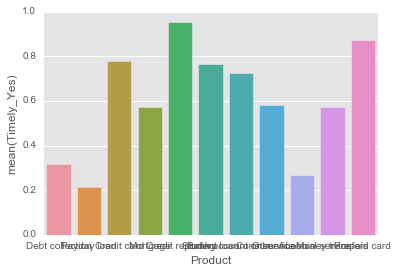

In [54]:
# plot product vs. mean timeliness
# commented rows sns.set_context("paper")
# plt.figure(figsize=(16, 10))
sns.barplot(x="Product", y="Timely_Yes", ci = None, data=train_df_desc);

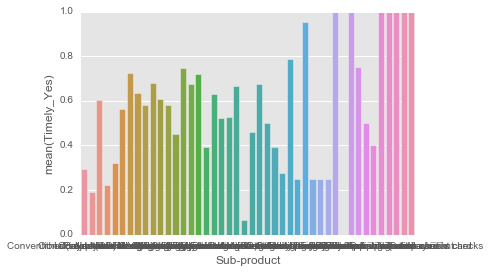

In [55]:
# plot sub-product vs. mean timeliness
# plt.figure(figsize=(16, 10))
sns.barplot(x="Sub-product", y="Timely_Yes", ci = None, data=train_df_desc);

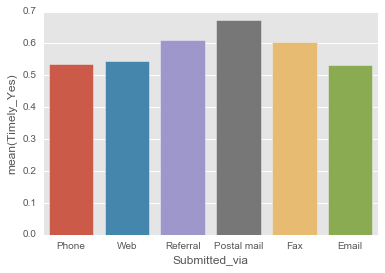

In [56]:
# plot submission method vs. mean timeliness
# plt.figure(figsize=(10, 8))
sns.barplot(x="Submitted_via", y="Timely_Yes", ci = None, data=train_df_desc);

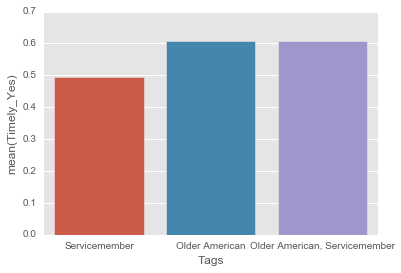

In [57]:
# plot social status vs. mean timeliness
# plt.figure(figsize=(16, 10))
sns.barplot(x="Tags", y="Timely_Yes", ci = None, data=train_df_desc);

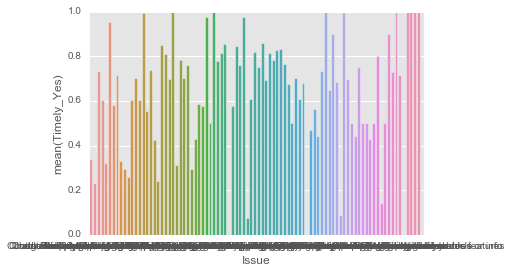

In [58]:
# plot issue vs. mean timeliness
# plt.figure(figsize=(16, 10))
sns.barplot(x="Issue", y="Timely_Yes", ci = None, data = train_df_desc);

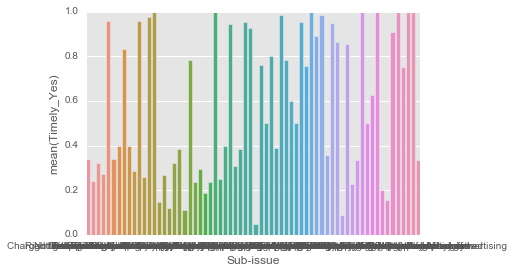

In [59]:
# plot sub-issue vs. mean timeliness
# plt.figure(figsize=(16, 10))
sns.barplot(x="Sub-issue", y="Timely_Yes", ci = None, data=train_df_desc);

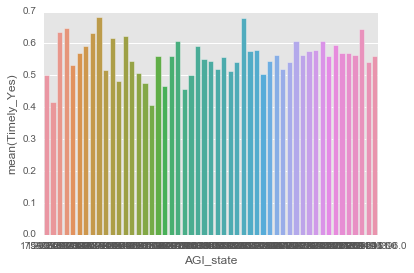

In [60]:
# plot AGI_state vs. mean timeliness
# plt.figure(figsize=(16, 10))
sns.barplot(x="AGI_state", y="Timely_Yes", ci = None, data=train_df_desc);

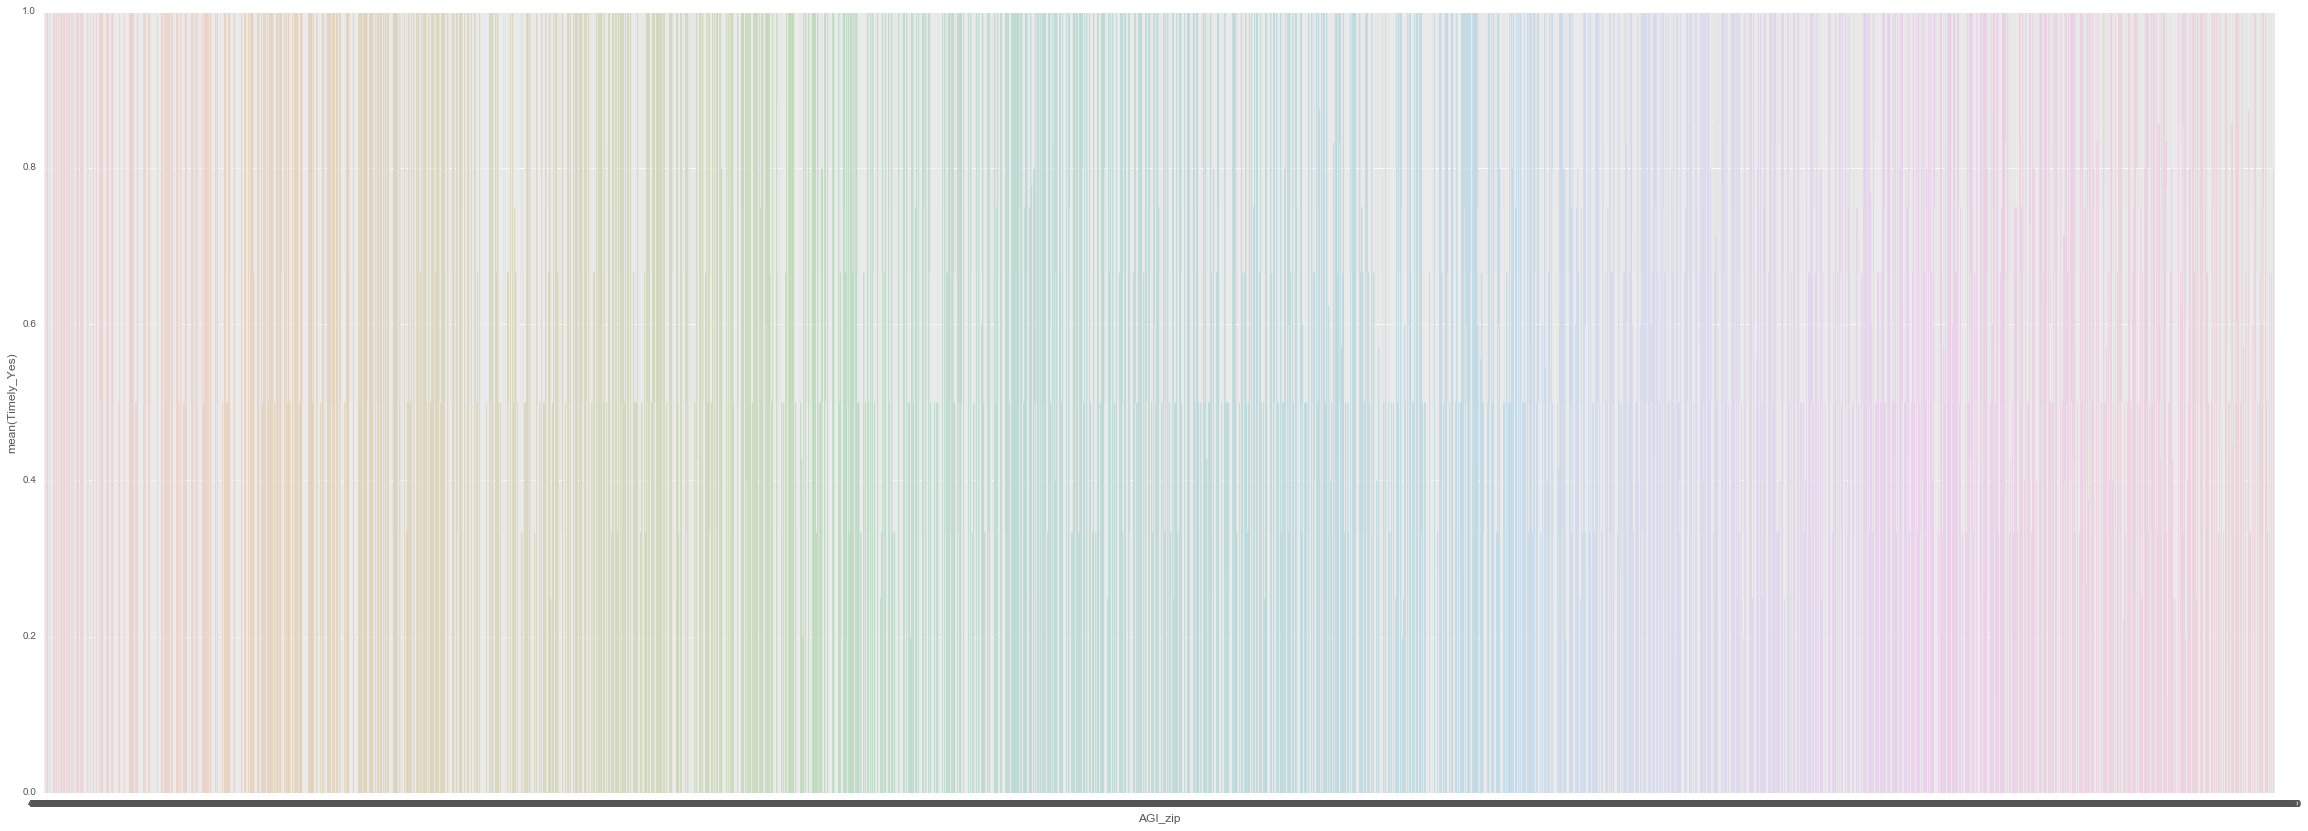

In [61]:
# plot AGI_zip vs. mean timeliness
plt.figure(figsize=(40, 14))
sns.barplot(x="AGI_zip", y="Timely_Yes", ci = None, data=train_df_desc);
# this demonstrates that zip code-level data is too granular

In [62]:
# Tabulate relationship between Company and Timely Response
Timely_Co_Tab = pd.crosstab(index = train_df_desc['Company'], columns = train_df_desc['Timely_Yes'], colnames = ['Timely'])

In [63]:
# Find the ten companies with the highest counts of untimely response
Timely_Co_Tab.sort_values(0.0, ascending = False).head(10)

Timely,0.0,1.0
Company,,
Bank of America,885,864
Ocwen,292,338
Wells Fargo & Company,186,740
Citibank,180,425
"Mobiloans, LLC",96,0
Residential Credit Solutions,89,11
Nationstar Mortgage,69,221
"Platinum Holdings Group, LLC",69,5
Premier Recovery Group,63,1


In [64]:
# Create a column for untimely response rate
Timely_Co_Tab['Untimely_Rate'] = (Timely_Co_Tab[0] / Timely_Co_Tab[1])

In [65]:
# Sort for the ten highest untimely response rates with secondary sort of number of untimely responses
Timely_Co_Tab.sort_values(['Untimely_Rate', 0.0], ascending = False).head(10)

Timely,0.0,1.0,Untimely_Rate
Company,,,
"Mobiloans, LLC",96,0,inf
Concord Resolution Inc (Closed),39,0,inf
Georgetown Mortgage,31,0,inf
High Point Asset Inc,31,0,inf
"Neighborhood Housing Services of Richmond, Inc",29,0,inf
"Rubin & Yates, LLC",22,0,inf
Hillcrest Davidson & Assoc,20,0,inf
"Clear Debt Solutions, LLC",19,0,inf
Marauder Corporation,19,0,inf


Part 3: Hypothesis Testing with Logistic Regression

In [66]:
# Regress Product variable
X1 = train_X.join([product_dummies])

In [67]:
logit = sm.Logit(train_y, X1)
logit = logit.fit()

Optimization terminated successfully.
         Current function value: 0.587474
         Iterations 7


In [68]:
logit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             Timely_Yes   No. Observations:                15580
Model:                          Logit   Df Residuals:                    15569
Method:                           MLE   Df Model:                           10
Date:                Sat, 09 Jul 2016   Pseudo R-squ.:                  0.1414
Time:                        12:21:30   Log-Likelihood:                -9152.8
converged:                       True   LL-Null:                       -10660.
                                        LLR p-value:                     0.000
===================================================================================================
                                      coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------------
Product_Bank account or service     0.9725      0.060     16.085      0.000         0.854     1.091
Product_Consumer Loan               0.3332      0.088      3.772      0.000         0.160     0.506
Product_Credit card                 1.2692      0.065     19.456      0.000         1.141     1.397
Product_Credit reporting            3.0025      0.119     25.210      0.000         2.769     3.236
Product_Debt collection            -0.7605      0.032    -24.136      0.000        -0.822    -0.699
Product_Money transfers             0.2948      0.223      1.320      0.187        -0.143     0.732
Product_Mortgage                    0.2923      0.028     10.587      0.000         0.238     0.346
Product_Other financial service    -1.0116      0.413     -2.450      0.014        -1.821    -0.202
Product_Payday loan                -1.3049      0.163     -8.019      0.000        -1.624    -0.986
Product_Prepaid card                1.9459      0.478      4.070      0.000         1.009     2.883
Product_Student loan                1.1733      0.123      9.509      0.000         0.931     1.415
===================================================================================================
"""

In [69]:
# Evaluate Product again without sole insignificant var ('Other Financial Service)
X1 = X1.drop('Product_Other financial service', axis = 1)
logit = sm.Logit(train_y, X1)
logit = logit.fit()
logit.summary()

Optimization terminated successfully.
         Current function value: 0.587692
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             Timely_Yes   No. Observations:                15580
Model:                          Logit   Df Residuals:                    15570
Method:                           MLE   Df Model:                            9
Date:                Sat, 09 Jul 2016   Pseudo R-squ.:                  0.1411
Time:                        12:21:30   Log-Likelihood:                -9156.2
converged:                       True   LL-Null:                       -10660.
                                        LLR p-value:                     0.000
===================================================================================================
                                      coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------------
Product_Bank account or service     0.9725      0.060     16.085      0.000         0.854     1.091
Product_Consumer Loan               0.3332      0.088      3.772      0.000         0.160     0.506
Product_Credit card                 1.2692      0.065     19.456      0.000         1.141     1.397
Product_Credit reporting            3.0025      0.119     25.210      0.000         2.769     3.236
Product_Debt collection            -0.7605      0.032    -24.136      0.000        -0.822    -0.699
Product_Money transfers             0.2948      0.223      1.320      0.187        -0.143     0.732
Product_Mortgage                    0.2923      0.028     10.587      0.000         0.238     0.346
Product_Payday loan                -1.3049      0.163     -8.019      0.000        -1.624    -0.986
Product_Prepaid card                1.9459      0.478      4.070      0.000         1.009     2.883
Product_Student loan                1.1733      0.123      9.509      0.000         0.931     1.415
===================================================================================================
"""

In [70]:
# Evaluate Product r-square with sklearn
product = linear_model.LogisticRegression()
product.fit(X1, train_y)
product.score(X1, train_y)

0.68395378690629016

In [71]:
# Can't evaluate Sub_Product variable -- too many values
X2 = train_X.join([sub_product_dummies])
# logit = sm.Logit(train_y, X2)
# logit = logit.fit()
# logit.summary()
print('cannot evaluate with StatsModels:', len(X2.columns), '> 30 variables')

cannot evaluate with StatsModels: 45 > 30 variables


In [72]:
# Evaluate Sub_Product r-square with sklearn
sub_product = linear_model.LogisticRegression()
sub_product.fit(X2, train_y)
sub_product.score(X2, train_y)

0.69024390243902434

In [73]:
# Can't evaluate Issue variable
X3 = train_X.join([issue_dummies])
# logit = sm.Logit(train_y, X3)
# logit = logit.fit()
#  --> Returns: Warning: Maximum number of iterations has been exceeded. Current function value: 0.575228 Iterations: 35
# Conclusion: too many features to test
print('cannot evaluate with StatsModels:', len(X3.columns), '> 30 variables')

cannot evaluate with StatsModels: 92 > 30 variables


In [74]:
# Evaluate Issue r-square with sklearn
issue = linear_model.LogisticRegression()
issue.fit(X3, train_y)
issue.score(X3, train_y)

0.69017971758664953

In [75]:
# Can't evaluate Sub_Issue variable
X4 = train_X.join([sub_issue_dummies])
# logit = sm.Logit(train_y, X4)
# logit = logit.fit()
# --> Returns: Warning: Maximum number of iterations has been exceeded. Current function value: 0.575228 Iterations: 35
# Conclusion: too many features to test
print('cannot r with StatsModels:', len(X4.columns), '> 30 variables')

cannot r with StatsModels: 67 > 30 variables


In [76]:
# Evaluate Sub_Issue r-square with sklearn
sub_issue = linear_model.LogisticRegression()
sub_issue.fit(X4, train_y)
sub_issue.score(X4, train_y)

0.68305519897304234

In [77]:
# Regress social status ('Tags') variable
X5 = train_X.join([tags_dummies])

In [78]:
logit = sm.Logit(train_y, X5)
logit = logit.fit()

Optimization terminated successfully.
         Current function value: 0.691228
         Iterations 4


In [79]:
logit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             Timely_Yes   No. Observations:                15580
Model:                          Logit   Df Residuals:                    15577
Method:                           MLE   Df Model:                            2
Date:                Sat, 09 Jul 2016   Pseudo R-squ.:                -0.01023
Time:                        12:21:30   Log-Likelihood:                -10769.
converged:                       True   LL-Null:                       -10660.
                                        LLR p-value:                     1.000
======================================================================================================
                                         coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------------------
Tags_Older American                    0.4332      0.061      7.069      0.000         0.313     0.553
Tags_Older American, Servicemember     0.4429      0.153      2.891      0.004         0.143     0.743
Tags_Servicemember                    -0.0205      0.072     -0.286      0.775        -0.161     0.120
======================================================================================================
"""

In [80]:
# Evaluate social status r-square with sklearn
tags = linear_model.LogisticRegression()
tags.fit(X5, train_y)
tags.score(X5, train_y)

0.56720154043645699

In [81]:
# Regress Products and Tags together

In [82]:
X6 = train_X.join([product_dummies, tags_dummies])

In [83]:
logit = sm.Logit(train_y, X6)
logit = logit.fit()

Optimization terminated successfully.
         Current function value: 0.587164
         Iterations 7


In [84]:
logit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             Timely_Yes   No. Observations:                15580
Model:                          Logit   Df Residuals:                    15566
Method:                           MLE   Df Model:                           13
Date:                Sat, 09 Jul 2016   Pseudo R-squ.:                  0.1419
Time:                        12:21:30   Log-Likelihood:                -9148.0
converged:                       True   LL-Null:                       -10660.
                                        LLR p-value:                     0.000
======================================================================================================
                                         coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------------------
Product_Bank account or service        0.9550      0.061     15.672      0.000         0.836     1.074
Product_Consumer Loan                  0.3156      0.089      3.553      0.000         0.142     0.490
Product_Credit card                    1.2520      0.066     19.067      0.000         1.123     1.381
Product_Credit reporting               2.9934      0.119     25.113      0.000         2.760     3.227
Product_Debt collection               -0.7733      0.033    -23.737      0.000        -0.837    -0.709
Product_Money transfers                0.2797      0.223      1.252      0.211        -0.158     0.718
Product_Mortgage                       0.2778      0.028      9.803      0.000         0.222     0.333
Product_Other financial service       -1.0544      0.414     -2.549      0.011        -1.865    -0.244
Product_Payday loan                   -1.3269      0.163     -8.132      0.000        -1.647    -1.007
Product_Prepaid card                   1.9428      0.478      4.064      0.000         1.006     2.880
Product_Student loan                   1.1695      0.123      9.470      0.000         0.927     1.412
Tags_Older American                    0.1402      0.069      2.023      0.043         0.004     0.276
Tags_Older American, Servicemember     0.3955      0.166      2.379      0.017         0.070     0.721
Tags_Servicemember                    -0.0099      0.081     -0.122      0.903        -0.169     0.149
======================================================================================================
"""

In [85]:
# Regress Debt Collection value for Product variable by itself

In [86]:
X7 = train_X.join([product_dummies])
X7 = X7[['Product_Debt collection']]

In [87]:
logit = sm.Logit(train_y, X7)
logit = logit.fit()
logit.summary()

Optimization terminated successfully.
         Current function value: 0.673078
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             Timely_Yes   No. Observations:                15580
Model:                          Logit   Df Residuals:                    15579
Method:                           MLE   Df Model:                            0
Date:                Sat, 09 Jul 2016   Pseudo R-squ.:                 0.01629
Time:                        12:21:30   Log-Likelihood:                -10487.
converged:                       True   LL-Null:                       -10660.
                                        LLR p-value:                       nan
===========================================================================================
                              coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------
Product_Debt collection    -0.7605      0.032    -24.136      0.000        -0.822    -0.699
===========================================================================================
"""

In [88]:
# Regress Submission Method
X9 = train_X.join([sub_method_dummies])

In [89]:
logit = sm.Logit(train_y, X9)
logit = logit.fit()
logit.summary()

Optimization terminated successfully.
         Current function value: 0.680999
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             Timely_Yes   No. Observations:                15580
Model:                          Logit   Df Residuals:                    15574
Method:                           MLE   Df Model:                            5
Date:                Sat, 09 Jul 2016   Pseudo R-squ.:                0.004716
Time:                        12:21:30   Log-Likelihood:                -10610.
converged:                       True   LL-Null:                       -10660.
                                        LLR p-value:                 4.040e-20
====================================================================================
                       coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Sub__Email           0.1335      0.518      0.258      0.796        -0.881     1.148
Sub__Fax             0.4190      0.130      3.221      0.001         0.164     0.674
Sub__Phone           0.1399      0.054      2.601      0.009         0.034     0.245
Sub__Postal mail     0.7280      0.068     10.761      0.000         0.595     0.861
Sub__Referral        0.4508      0.036     12.500      0.000         0.380     0.521
Sub__Web             0.1788      0.020      8.772      0.000         0.139     0.219
====================================================================================
"""

In [90]:
# Eliminate lowest z-scores and retest Submission Method
X9 = X9.drop('Sub__Email', axis = 1)
logit = sm.Logit(train_y, X9)
logit = logit.fit()
logit.summary()

Optimization terminated successfully.
         Current function value: 0.681001
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             Timely_Yes   No. Observations:                15580
Model:                          Logit   Df Residuals:                    15575
Method:                           MLE   Df Model:                            4
Date:                Sat, 09 Jul 2016   Pseudo R-squ.:                0.004713
Time:                        12:21:30   Log-Likelihood:                -10610.
converged:                       True   LL-Null:                       -10660.
                                        LLR p-value:                 7.749e-21
====================================================================================
                       coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Sub__Fax             0.4190      0.130      3.221      0.001         0.164     0.674
Sub__Phone           0.1399      0.054      2.601      0.009         0.034     0.245
Sub__Postal mail     0.7280      0.068     10.761      0.000         0.595     0.861
Sub__Referral        0.4508      0.036     12.500      0.000         0.380     0.521
Sub__Web             0.1788      0.020      8.772      0.000         0.139     0.219
====================================================================================
"""

In [91]:
# Regress all significant values from Product variable and Older American, Servicemember from regression 6
X9 = train_X.join([product_dummies, tags_dummies])
X9 = X9.drop(['Product_Other financial service', 'Tags_Older American, Servicemember', 'Tags_Servicemember'], axis = 1)

In [92]:
logit = sm.Logit(train_y, X9)
logit = logit.fit()
logit.summary()

Optimization terminated successfully.
         Current function value: 0.587574
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             Timely_Yes   No. Observations:                15580
Model:                          Logit   Df Residuals:                    15569
Method:                           MLE   Df Model:                           10
Date:                Sat, 09 Jul 2016   Pseudo R-squ.:                  0.1413
Time:                        12:21:30   Log-Likelihood:                -9154.4
converged:                       True   LL-Null:                       -10660.
                                        LLR p-value:                     0.000
===================================================================================================
                                      coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------------
Product_Bank account or service     0.9603      0.061     15.799      0.000         0.841     1.079
Product_Consumer Loan               0.3240      0.088      3.663      0.000         0.151     0.497
Product_Credit card                 1.2561      0.066     19.153      0.000         1.128     1.385
Product_Credit reporting            2.9952      0.119     25.137      0.000         2.762     3.229
Product_Debt collection            -0.7688      0.032    -24.161      0.000        -0.831    -0.706
Product_Money transfers             0.2804      0.223      1.255      0.209        -0.157     0.718
Product_Mortgage                    0.2825      0.028     10.063      0.000         0.227     0.337
Product_Payday loan                -1.3116      0.163     -8.057      0.000        -1.631    -0.993
Product_Prepaid card                1.9428      0.478      4.063      0.000         1.006     2.880
Product_Student loan                1.1701      0.123      9.482      0.000         0.928     1.412
Tags_Older American                 0.1322      0.069      1.913      0.056        -0.003     0.268
===================================================================================================
"""

In [93]:
# Evaluate state-level income variable
X10 = train_X.join([agi_cols])
X10 = X10.drop('AGI_zip', axis = 1)
logit = sm.Logit(train_y, X10)
logit = logit.fit()
logit.summary()

Optimization terminated successfully.
         Current function value: 0.687255
         Iterations 1


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             Timely_Yes   No. Observations:                15580
Model:                          Logit   Df Residuals:                    15579
Method:                           MLE   Df Model:                            0
Date:                Sat, 09 Jul 2016   Pseudo R-squ.:               -0.004427
Time:                        12:21:30   Log-Likelihood:                -10707.
converged:                       True   LL-Null:                       -10660.
                                        LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
AGI_state   3.629e-10   2.73e-11     13.285      0.000      3.09e-10  4.16e-10
==============================================================================
"""

In [94]:
# Evaluate zip-level income variable
X11 = train_X.join([agi_cols])
X11 = X11.drop('AGI_state', axis = 1)
logit = sm.Logit(train_y, X11)
logit = logit.fit()
logit.summary()

Optimization terminated successfully.
         Current function value: 0.686587
         Iterations 3


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             Timely_Yes   No. Observations:                15580
Model:                          Logit   Df Residuals:                    15579
Method:                           MLE   Df Model:                            0
Date:                Sat, 09 Jul 2016   Pseudo R-squ.:               -0.003451
Time:                        12:21:30   Log-Likelihood:                -10697.
converged:                       True   LL-Null:                       -10660.
                                        LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
AGI_zip     1.745e-07   1.26e-08     13.865      0.000       1.5e-07  1.99e-07
==============================================================================
"""

In [95]:
# Create Product, Tags, and State-Level Income feature set
X12 = X6.join([agi_cols]).drop('AGI_zip', axis = 1)

In [96]:
# Regress Product and State-Level Income against timeliness
logit = sm.Logit(train_y, X12)
logit = logit.fit()
logit.summary()

Optimization terminated successfully.
         Current function value: 0.587163
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             Timely_Yes   No. Observations:                15580
Model:                          Logit   Df Residuals:                    15565
Method:                           MLE   Df Model:                           14
Date:                Sat, 09 Jul 2016   Pseudo R-squ.:                  0.1419
Time:                        12:21:31   Log-Likelihood:                -9148.0
converged:                       True   LL-Null:                       -10660.
                                        LLR p-value:                     0.000
======================================================================================================
                                         coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------------------
Product_Bank account or service        0.9519      0.065     14.714      0.000         0.825     1.079
Product_Consumer Loan                  0.3127      0.091      3.430      0.001         0.134     0.491
Product_Credit card                    1.2489      0.069     18.073      0.000         1.113     1.384
Product_Credit reporting               2.9901      0.121     24.638      0.000         2.752     3.228
Product_Debt collection               -0.7764      0.039    -19.828      0.000        -0.853    -0.700
Product_Money transfers                0.2767      0.224      1.233      0.218        -0.163     0.717
Product_Mortgage                       0.2745      0.037      7.520      0.000         0.203     0.346
Product_Other financial service       -1.0575      0.414     -2.553      0.011        -1.869    -0.246
Product_Payday loan                   -1.3296      0.164     -8.092      0.000        -1.652    -1.008
Product_Prepaid card                   1.9395      0.479      4.052      0.000         1.001     2.878
Product_Student loan                   1.1668      0.125      9.344      0.000         0.922     1.412
Tags_Older American                    0.1401      0.069      2.020      0.043         0.004     0.276
Tags_Older American, Servicemember     0.3956      0.166      2.380      0.017         0.070     0.721
Tags_Servicemember                    -0.0097      0.081     -0.120      0.905        -0.169     0.149
AGI_state                           6.822e-12   4.75e-11      0.144      0.886     -8.63e-11  9.99e-11
======================================================================================================
"""

In [97]:
# Create Product, Tags, and State-Level Income feature set
X15 = X6.join([agi_cols]).drop('AGI_state', axis = 1)

In [98]:
# Regress Product and State-Level Income against timeliness
logit = sm.Logit(train_y, X15)
logit = logit.fit()
logit.summary()

Optimization terminated successfully.
         Current function value: 0.587152
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             Timely_Yes   No. Observations:                15580
Model:                          Logit   Df Residuals:                    15565
Method:                           MLE   Df Model:                           14
Date:                Sat, 09 Jul 2016   Pseudo R-squ.:                  0.1419
Time:                        12:21:31   Log-Likelihood:                -9147.8
converged:                       True   LL-Null:                       -10660.
                                        LLR p-value:                     0.000
======================================================================================================
                                         coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------------------
Product_Bank account or service        0.9423      0.064     14.633      0.000         0.816     1.068
Product_Consumer Loan                  0.3041      0.091      3.348      0.001         0.126     0.482
Product_Credit card                    1.2384      0.069     17.876      0.000         1.103     1.374
Product_Credit reporting               2.9812      0.121     24.670      0.000         2.744     3.218
Product_Debt collection               -0.7848      0.038    -20.831      0.000        -0.859    -0.711
Product_Money transfers                0.2683      0.224      1.197      0.231        -0.171     0.708
Product_Mortgage                       0.2654      0.035      7.606      0.000         0.197     0.334
Product_Other financial service       -1.0651      0.414     -2.573      0.010        -1.877    -0.254
Product_Payday loan                   -1.3379      0.164     -8.150      0.000        -1.660    -1.016
Product_Prepaid card                   1.9333      0.478      4.041      0.000         0.996     2.871
Product_Student loan                   1.1580      0.125      9.269      0.000         0.913     1.403
Tags_Older American                    0.1407      0.069      2.029      0.042         0.005     0.277
Tags_Older American, Servicemember     0.3973      0.166      2.390      0.017         0.071     0.723
Tags_Servicemember                    -0.0088      0.081     -0.109      0.914        -0.168     0.150
AGI_zip                             1.192e-08   1.95e-08      0.611      0.541     -2.63e-08  5.02e-08
======================================================================================================
"""

In [99]:
# Evaluate Debt Collection with Scikitlearn
debt_collection = linear_model.LogisticRegression()
debt_collection.fit(X7, train_y)
debt_collection.score(X7, train_y)

0.67477535301668801

In [100]:
# Evaluate Product and Tags model with Scikitlearn's LogisticRegression function
product_tags = linear_model.LogisticRegression()
product_tags.fit(X9, train_y)
product_tags.score(X9, train_y)

0.68376123234916564

In [101]:
# Evaluate Sub-Product and Tags model with Scikitlearn's LogisticRegression function
sub_product_tags = linear_model.LogisticRegression()
sub_product_tags.fit(X11, train_y)
sub_product_tags.score(X11, train_y)

0.56668806161745833

In [102]:
# Plot the residuals and identify potential remaining sources of signal if they do follow a pattern
# https://github.com/ga-students/DS-SF-23/blob/56f0e85decd927c22692120998506689d39b93e2/classes/06/code/lab-06-introduction-to-regression-and-model-fit-answer-key.ipynb
# Plot residuals of both Sklearn and Statsmodel
# figure = sm.qqplot(logit.resid, line = 's')

In [103]:
# Evaluate Product without sole insignificant var ('Other Financial Service) on test data
X9_test = test_X.join([product_dummies, tags_dummies])
X9_test = X9_test.drop(['Product_Other financial service', 'Tags_Older American, Servicemember', 'Tags_Servicemember'], axis = 1)

In [104]:
X9_test.head()

,Product_Bank account or service,Product_Consumer Loan,Product_Credit card,Product_Credit reporting,Product_Debt collection,Product_Money transfers,Product_Mortgage,Product_Payday loan,Product_Prepaid card,Product_Student loan,Tags_Older American
443543,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69787,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
129661,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
8567,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
153548,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [105]:
logit = sm.Logit(test_y, X9_test)
logit = logit.fit()
logit.summary()

Optimization terminated successfully.
         Current function value: 0.592982
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             Timely_Yes   No. Observations:                10386
Model:                          Logit   Df Residuals:                    10375
Method:                           MLE   Df Model:                           10
Date:                Sat, 09 Jul 2016   Pseudo R-squ.:                  0.1360
Time:                        12:21:31   Log-Likelihood:                -6158.7
converged:                       True   LL-Null:                       -7128.1
                                        LLR p-value:                     0.000
===================================================================================================
                                      coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------------
Product_Bank account or service     0.9976      0.075     13.355      0.000         0.851     1.144
Product_Consumer Loan               0.1491      0.109      1.368      0.171        -0.064     0.363
Product_Credit card                 1.0475      0.076     13.870      0.000         0.899     1.195
Product_Credit reporting            3.1510      0.160     19.748      0.000         2.838     3.464
Product_Debt collection            -0.7844      0.040    -19.800      0.000        -0.862    -0.707
Product_Money transfers             0.8574      0.298      2.875      0.004         0.273     1.442
Product_Mortgage                    0.2555      0.034      7.610      0.000         0.190     0.321
Product_Payday loan                -1.4232      0.211     -6.758      0.000        -1.836    -1.010
Product_Prepaid card                0.4562      0.369      1.237      0.216        -0.267     1.179
Product_Student loan                0.9376      0.151      6.208      0.000         0.642     1.234
Tags_Older American                 0.0517      0.084      0.615      0.538        -0.113     0.216
===================================================================================================
"""